# pycisTopic analysis

Full dataset, using SCREEN regions.

In [25]:
import pycisTopic
pycisTopic.__version__

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pickle
import pandas as pd

import os


import glob
from collections import OrderedDict
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [26]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/full_2_cistopic


<IPython.core.display.Javascript object>

In [27]:
wdir = '/lustre1/project/stg_00090/scatac_benchmark/full_2_cistopic'
os.chdir(wdir)

<IPython.core.display.Javascript object>

## Create the cisTopic objects for each sample

Make a new output dir

In [28]:
cistopic_objects_out = 'cistopic_objects'
if not os.path.exists(os.path.join(wdir, cistopic_objects_out)):
    os.makedirs(os.path.join(wdir, cistopic_objects_out))

<IPython.core.display.Javascript object>

Create a dictionary with fragments files for each sample

In [29]:
filenames = sorted(glob.glob('../1_data_repository/full_fragments/*.fragments.tsv.gz'))
fragments_dict = {}
for filename in filenames:
    sample = filename.split('/')[-1].split('.fragments.tsv.gz')[0]
    fragments_dict[sample] = filename
fragments_dict

{'BIO_ddseq_1.FULL': '../1_data_repository/full_fragments/BIO_ddseq_1.FULL.fragments.tsv.gz',
 'BIO_ddseq_2.FULL': '../1_data_repository/full_fragments/BIO_ddseq_2.FULL.fragments.tsv.gz',
 'BIO_ddseq_3.FULL': '../1_data_repository/full_fragments/BIO_ddseq_3.FULL.fragments.tsv.gz',
 'BIO_ddseq_4.FULL': '../1_data_repository/full_fragments/BIO_ddseq_4.FULL.fragments.tsv.gz',
 'BRO_mtscatac_1.FULL': '../1_data_repository/full_fragments/BRO_mtscatac_1.FULL.fragments.tsv.gz',
 'BRO_mtscatac_2.FULL': '../1_data_repository/full_fragments/BRO_mtscatac_2.FULL.fragments.tsv.gz',
 'CNA_10xmultiome_1.FULL': '../1_data_repository/full_fragments/CNA_10xmultiome_1.FULL.fragments.tsv.gz',
 'CNA_10xmultiome_2.FULL': '../1_data_repository/full_fragments/CNA_10xmultiome_2.FULL.fragments.tsv.gz',
 'CNA_10xv11_1.FULL': '../1_data_repository/full_fragments/CNA_10xv11_1.FULL.fragments.tsv.gz',
 'CNA_10xv11_2.FULL': '../1_data_repository/full_fragments/CNA_10xv11_2.FULL.fragments.tsv.gz',
 'CNA_10xv11_3.FULL'

<IPython.core.display.Javascript object>

In [30]:
fragments_sub_dict = {}
#regions_sub_dict = {}
for sample in fragments_dict:
    cto = os.path.join(cistopic_objects_out, sample + "__cto.pkl")
    print(f"Checking if {cto} exist...")
    if os.path.exists(cto):
        print(f"\t{cto} exists! Skipping...")
    else:
        print(f"\t{cto} does not exist, adding to subdict to generate")
        fragments_sub_dict[sample] = fragments_dict[sample]
        metadata_bc_sub_dict = {}
        bc_passing_filters_sub_dict = {}
        for sample in fragments_sub_dict.keys():
            metadata_bc_sub_dict[sample] = f"cistopic_qc_out/{sample}__metadata_bc.pkl"
            bc_passing_filters_sub_dict[sample] = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"

Checking if cistopic_objects/BIO_ddseq_1.FULL__cto.pkl exist...
	cistopic_objects/BIO_ddseq_1.FULL__cto.pkl exists! Skipping...
Checking if cistopic_objects/BIO_ddseq_2.FULL__cto.pkl exist...
	cistopic_objects/BIO_ddseq_2.FULL__cto.pkl exists! Skipping...
Checking if cistopic_objects/BIO_ddseq_3.FULL__cto.pkl exist...
	cistopic_objects/BIO_ddseq_3.FULL__cto.pkl exists! Skipping...
Checking if cistopic_objects/BIO_ddseq_4.FULL__cto.pkl exist...
	cistopic_objects/BIO_ddseq_4.FULL__cto.pkl exists! Skipping...
Checking if cistopic_objects/BRO_mtscatac_1.FULL__cto.pkl exist...
	cistopic_objects/BRO_mtscatac_1.FULL__cto.pkl exists! Skipping...
Checking if cistopic_objects/BRO_mtscatac_2.FULL__cto.pkl exist...
	cistopic_objects/BRO_mtscatac_2.FULL__cto.pkl exists! Skipping...
Checking if cistopic_objects/CNA_10xmultiome_1.FULL__cto.pkl exist...
	cistopic_objects/CNA_10xmultiome_1.FULL__cto.pkl exists! Skipping...
Checking if cistopic_objects/CNA_10xmultiome_2.FULL__cto.pkl exist...
	cistopic_

<IPython.core.display.Javascript object>

Read bed files for SCREEN regions and blacklist (blacklisted regions in genome where many reads can map)

In [31]:
path_to_regions = '../0_resources/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed'
path_to_blacklist = '../0_resources/regions/hg38-blacklist.v2.bed'

<IPython.core.display.Javascript object>

Create cistopic objects for each sample. If pandas crashes, increase the number of partitions. This is necessary for the largest files.

In the following command, it is important that the barcode syntax matches the fragments, the metadata and the bc_passing filters. That is why the sample name is removed from metadata and bc passing filters.

In [32]:
if fragments_sub_dict != {}:
    from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
    n_cores = 20
    for sample in fragments_sub_dict.keys():
        cto_path = os.path.join(cistopic_objects_out, f"{sample}__cto.pkl")
        if not os.path.exists(cto_path):
            infile = open(metadata_bc_sub_dict[sample], 'rb')
            metadata_bc = pickle.load(infile)
            metadata_bc.index = [bc.split("___")[0] for bc in metadata_bc.index]
            infile.close()
            infile = open(bc_passing_filters_sub_dict[sample], 'rb')
            bc_passing_filters = pickle.load(infile)
            infile.close()
            bc_passing_filters_fixed = [bc.split("___")[0] for bc in bc_passing_filters]
            cto = create_cistopic_object_from_fragments(path_to_fragments=fragments_sub_dict[sample],
                                                            path_to_regions=path_to_regions,
                                                            path_to_blacklist=path_to_blacklist,
                                                            metrics=metadata_bc,
                                                            valid_bc=bc_passing_filters_fixed,
                                                            n_cpu=n_cores,
                                                            partition=10,
                                                            project=sample)

            cto_path = os.path.join(cistopic_objects_out, f"{sample}__cto.pkl")
            print(f"Writing {sample} cto in {cto_path}...")

            with open(
                cto_path, "wb"
            ) as f:
                pickle.dump(cto, f, protocol=4)

        else:
            print(f"{cto_path} already exists!")

else:
    print("All samples already processed.")

All samples already processed.


<IPython.core.display.Javascript object>

# Run Scrublet

In [33]:
import scrublet as scr
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [34]:
cto_dict = {x.split('/')[-1].split('__cto.pkl')[0]:x for x in sorted(glob.glob('cistopic_objects/*__cto.pkl'))}
cto_dict

{'BIO_ddseq_1.FULL': 'cistopic_objects/BIO_ddseq_1.FULL__cto.pkl',
 'BIO_ddseq_2.FULL': 'cistopic_objects/BIO_ddseq_2.FULL__cto.pkl',
 'BIO_ddseq_3.FULL': 'cistopic_objects/BIO_ddseq_3.FULL__cto.pkl',
 'BIO_ddseq_4.FULL': 'cistopic_objects/BIO_ddseq_4.FULL__cto.pkl',
 'BRO_mtscatac_1.FULL': 'cistopic_objects/BRO_mtscatac_1.FULL__cto.pkl',
 'BRO_mtscatac_2.FULL': 'cistopic_objects/BRO_mtscatac_2.FULL__cto.pkl',
 'CNA_10xmultiome_1.FULL': 'cistopic_objects/CNA_10xmultiome_1.FULL__cto.pkl',
 'CNA_10xmultiome_2.FULL': 'cistopic_objects/CNA_10xmultiome_2.FULL__cto.pkl',
 'CNA_10xv11_1.FULL': 'cistopic_objects/CNA_10xv11_1.FULL__cto.pkl',
 'CNA_10xv11_2.FULL': 'cistopic_objects/CNA_10xv11_2.FULL__cto.pkl',
 'CNA_10xv11_3.FULL': 'cistopic_objects/CNA_10xv11_3.FULL__cto.pkl',
 'CNA_10xv11_4.FULL': 'cistopic_objects/CNA_10xv11_4.FULL__cto.pkl',
 'CNA_10xv11_5.FULL': 'cistopic_objects/CNA_10xv11_5.FULL__cto.pkl',
 'CNA_10xv2_1.FULL': 'cistopic_objects/CNA_10xv2_1.FULL__cto.pkl',
 'CNA_10xv2_2.FU

<IPython.core.display.Javascript object>

In [35]:
fragments_sub_dict = {}
scrubcto_dict = {}
scrub_threshold = 0.4
scrub_name_suffix = "0-4"
#regions_sub_dict = {}
for sample in cto_dict:
    cto = os.path.join('cistopic_objects', sample + f"__cto.scrublet{scrub_name_suffix}.pkl")
    print(f"Checking if {cto} exist...")
    if os.path.exists(cto):
        print(f"\t{cto} exists! Skipping...")
    else:
        print(f"\t{cto} does not exist, adding to subdict to generate")
        scrubcto_dict[sample] = cto

Checking if cistopic_objects/BIO_ddseq_1.FULL__cto.scrublet0-4.pkl exist...
	cistopic_objects/BIO_ddseq_1.FULL__cto.scrublet0-4.pkl exists! Skipping...
Checking if cistopic_objects/BIO_ddseq_2.FULL__cto.scrublet0-4.pkl exist...
	cistopic_objects/BIO_ddseq_2.FULL__cto.scrublet0-4.pkl exists! Skipping...
Checking if cistopic_objects/BIO_ddseq_3.FULL__cto.scrublet0-4.pkl exist...
	cistopic_objects/BIO_ddseq_3.FULL__cto.scrublet0-4.pkl exists! Skipping...
Checking if cistopic_objects/BIO_ddseq_4.FULL__cto.scrublet0-4.pkl exist...
	cistopic_objects/BIO_ddseq_4.FULL__cto.scrublet0-4.pkl exists! Skipping...
Checking if cistopic_objects/BRO_mtscatac_1.FULL__cto.scrublet0-4.pkl exist...
	cistopic_objects/BRO_mtscatac_1.FULL__cto.scrublet0-4.pkl exists! Skipping...
Checking if cistopic_objects/BRO_mtscatac_2.FULL__cto.scrublet0-4.pkl exist...
	cistopic_objects/BRO_mtscatac_2.FULL__cto.scrublet0-4.pkl exists! Skipping...
Checking if cistopic_objects/CNA_10xmultiome_1.FULL__cto.scrublet0-4.pkl exi

<IPython.core.display.Javascript object>

Loaded cistopic_objects/VIB_hydrop_1.FULL__cto.pkl
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 9.7%
Estimated detectable doublet fraction = 45.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 21.5%
Elapsed time: 5.8 seconds
Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.2%


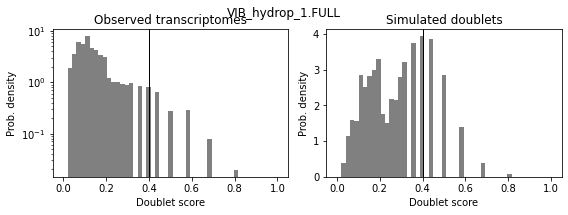

Running UMAP...


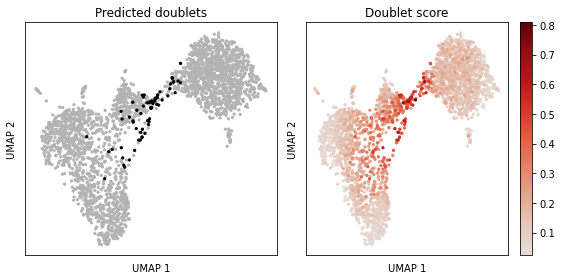

VIB_hydrop_1.FULL: found doublets: 
	(2524: Scrublet)


Loaded cistopic_objects/VIB_hydrop_2.FULL__cto.pkl
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 9.2 seconds
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 17.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.9%


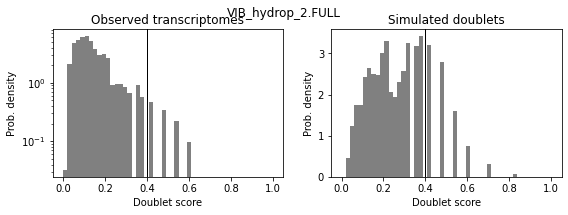

Running UMAP...


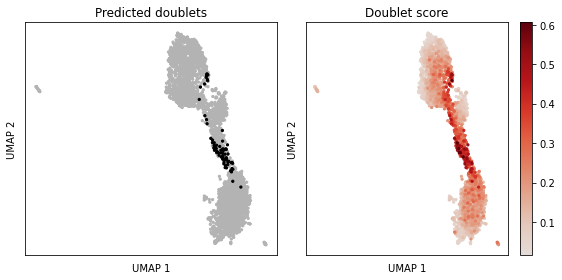

VIB_hydrop_2.FULL: found doublets: 
	(3042: Scrublet)




<IPython.core.display.Javascript object>

In [36]:
if cto_dict != {}:
    for sample in scrubcto_dict.keys():
        with open(cto_dict[sample], 'rb') as f:
            cto = pickle.load(f)
        print(f"Loaded {cto_dict[sample]}")
        scrub = scr.Scrublet(cto.fragment_matrix.T, expected_doublet_rate=0.1)
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        # scrub.plot_histogram()
        scrub.call_doublets(threshold=scrub_threshold)
        a,b = scrub.plot_histogram()
        a.suptitle(sample)
        plt.savefig(f'plots_qc/{sample}.scrublet_histogram.png', dpi=150, facecolor='white')
        plt.show()
        plt.close()

        print('Running UMAP...')
        scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
        scrub.plot_embedding('UMAP', order_points=True);
        plt.savefig(f'plots_qc/{sample}.scrublet_umap.png', dpi=150, facecolor='white')
        plt.show()
        plt.close()

        scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], 
            columns=cto.cell_names,
            index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T
        cto.add_cell_data(scrublet)
        n_scrublet_doublets = len(cto.cell_data["Predicted_doublets_fragments"] == True)
        print(f"{sample}: found doublets: \n\t({n_scrublet_doublets}: Scrublet)"
             )

        cto_path_new = scrubcto_dict[sample]

        with open(
            cto_path_new, "wb"
        ) as f:
            pickle.dump(cto, f, protocol=4)

        print('\n')
        
else:
    print("All samples already processed.")

## Cell filtering

### Read in Freemuxlet doublet predictions

In [37]:
f_fmx = 'out_fmx/genotype_concordance_unified.txt'
fmx = pd.read_csv(f_fmx, sep='\t')
fmx

,INT_ID,BARCODE,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,...,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL,ubarcode,replicate,sample
CNA_mtscatac_1.FULL.1,0,GTCCCAGGAAAGGCCA,2339,2339,SNG,"1,1",-4102.33,"1,0",-4403.45,301.12,...,-4102.33,0,-5006.85,1.00000,"1,0",-4403.45,301.12,CNA_mtscatac_1.FULL#GTCCCAGGAAAGGCCA,CNA_mtscatac_1.FULL,sampleA
CNA_mtscatac_1.FULL.2,1,TGCGAGGCTCTGCCAG,1738,1738,SNG,"0,0",-3068.55,"1,0",-3307.30,238.75,...,-3068.55,1,-3808.83,1.00000,"1,0",-3307.30,238.75,CNA_mtscatac_1.FULL#TGCGAGGCTCTGCCAG,CNA_mtscatac_1.FULL,sampleB
CNA_mtscatac_1.FULL.3,2,AGCGTATACCAATAGA,5432,5432,SNG,"1,1",-9844.04,"1,0",-10194.35,350.30,...,-9844.04,0,-11116.48,1.00000,"1,0",-10194.35,350.30,CNA_mtscatac_1.FULL#AGCGTATACCAATAGA,CNA_mtscatac_1.FULL,sampleA
CNA_mtscatac_1.FULL.4,3,TGTCGAAACGACCGAA,1196,1196,SNG,"1,1",-2089.42,"1,0",-2240.71,151.28,...,-2089.42,0,-2537.00,1.00000,"1,0",-2240.71,151.28,CNA_mtscatac_1.FULL#TGTCGAAACGACCGAA,CNA_mtscatac_1.FULL,sampleA
CNA_mtscatac_1.FULL.5,4,AGGTCAGGACGGTTGC,6424,6424,SNG,"1,1",-11307.49,"1,0",-12145.77,838.28,...,-11307.49,0,-13886.90,1.00000,"1,0",-12145.77,838.28,CNA_mtscatac_1.FULL#AGGTCAGGACGGTTGC,CNA_mtscatac_1.FULL,sampleA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIB_hydrop_22.FULL.965,964,TAACCGAATCTCTCGCACGA,227,227,SNG,"0,0",-404.03,"1,0",-432.16,28.13,...,-404.03,1,-495.29,1.00000,"1,0",-432.16,28.13,VIB_hydrop_22.FULL#TAACCGAATCTCTCGCACGA,VIB_hydrop_22.FULL,sampleB
VIB_hydrop_22.FULL.966,965,AACGATACCATGCTTGCCGT,175,175,SNG,"0,0",-315.26,"1,0",-335.18,19.92,...,-315.26,1,-385.62,1.00000,"1,0",-335.18,19.92,VIB_hydrop_22.FULL#AACGATACCATGCTTGCCGT,VIB_hydrop_22.FULL,sampleB
VIB_hydrop_22.FULL.967,966,GATTGGCGGTGTCCAGGCTT,274,274,SNG,"0,0",-481.27,"1,0",-513.34,32.07,...,-481.27,1,-582.89,1.00000,"1,0",-513.34,32.07,VIB_hydrop_22.FULL#GATTGGCGGTGTCCAGGCTT,VIB_hydrop_22.FULL,sampleB
VIB_hydrop_22.FULL.968,967,CGTTGACCACGGTAGGTAGG,172,172,SNG,"1,1",-312.80,"1,0",-321.39,8.59,...,-312.80,0,-342.76,1.00000,"1,0",-321.39,8.59,VIB_hydrop_22.FULL#CGTTGACCACGGTAGGTAGG,VIB_hydrop_22.FULL,sampleA


<IPython.core.display.Javascript object>

In [38]:
fmx['DROPLET.TYPE'].unique()

array(['SNG', 'DBL'], dtype=object)

<IPython.core.display.Javascript object>

In [39]:
# create an annotation df:
fmx['cell_names'] = fmx['BARCODE'] + "___" + fmx['replicate']

fmx_annot = fmx[['DROPLET.TYPE','sample','cell_names']].copy().set_index('cell_names')
fmx_annot.columns = ['fmx_droplet_type','fmx_sample']
fmx_annot

,fmx_droplet_type,fmx_sample
cell_names,,
GTCCCAGGAAAGGCCA___CNA_mtscatac_1.FULL,SNG,sampleA
TGCGAGGCTCTGCCAG___CNA_mtscatac_1.FULL,SNG,sampleB
AGCGTATACCAATAGA___CNA_mtscatac_1.FULL,SNG,sampleA
TGTCGAAACGACCGAA___CNA_mtscatac_1.FULL,SNG,sampleA
AGGTCAGGACGGTTGC___CNA_mtscatac_1.FULL,SNG,sampleA
...,...,...
TAACCGAATCTCTCGCACGA___VIB_hydrop_22.FULL,SNG,sampleB
AACGATACCATGCTTGCCGT___VIB_hydrop_22.FULL,SNG,sampleB
GATTGGCGGTGTCCAGGCTT___VIB_hydrop_22.FULL,SNG,sampleB


<IPython.core.display.Javascript object>

In [40]:
fmx_samples = sorted(list(set([x.split('.')[0] + '.' + x.split('.')[1] for x in fmx.index])))
[x for x in fmx_samples]

['BRO_mtscatac_1.FULL',
 'BRO_mtscatac_2.FULL',
 'CNA_10xmultiome_1.FULL',
 'CNA_10xmultiome_2.FULL',
 'CNA_10xv11_1.FULL',
 'CNA_10xv11_2.FULL',
 'CNA_10xv11_3.FULL',
 'CNA_10xv11_4.FULL',
 'CNA_10xv11_5.FULL',
 'CNA_10xv2_1.FULL',
 'CNA_10xv2_2.FULL',
 'CNA_hydrop_1.FULL',
 'CNA_hydrop_2.FULL',
 'CNA_hydrop_3.FULL',
 'CNA_mtscatac_1.FULL',
 'CNA_mtscatac_2.FULL',
 'EPF_hydrop_1.FULL',
 'EPF_hydrop_2.FULL',
 'EPF_hydrop_3.FULL',
 'EPF_hydrop_4.FULL',
 'HAR_ddseq_1.FULL',
 'HAR_ddseq_2.FULL',
 'MDC_mtscatac_1.FULL',
 'MDC_mtscatac_2.FULL',
 'SAN_10xmultiome_1.FULL',
 'SAN_10xmultiome_2.FULL',
 'STA_10xv11_1.FULL',
 'STA_10xv11_2.FULL',
 'VIB_10xmultiome_1.FULL',
 'VIB_10xmultiome_2.FULL',
 'VIB_10xv1_1.FULL',
 'VIB_10xv1_2.FULL',
 'VIB_10xv2_1.FULL',
 'VIB_10xv2_2.FULL',
 'VIB_hydrop_11.FULL',
 'VIB_hydrop_12.FULL',
 'VIB_hydrop_21.FULL',
 'VIB_hydrop_22.FULL']

<IPython.core.display.Javascript object>

In [41]:
print(len(fmx_samples))

38


<IPython.core.display.Javascript object>

# Read scrublet ctos

In [42]:
scrubcto_dict = {x.split('/')[-1].split(f'__cto.scrublet{scrub_name_suffix}.pkl')[0]:x for x in sorted(glob.glob(f'cistopic_objects/*__cto.scrublet{scrub_name_suffix}.pkl'))}
scrubcto_dict

{'BIO_ddseq_1.FULL': 'cistopic_objects/BIO_ddseq_1.FULL__cto.scrublet0-4.pkl',
 'BIO_ddseq_2.FULL': 'cistopic_objects/BIO_ddseq_2.FULL__cto.scrublet0-4.pkl',
 'BIO_ddseq_3.FULL': 'cistopic_objects/BIO_ddseq_3.FULL__cto.scrublet0-4.pkl',
 'BIO_ddseq_4.FULL': 'cistopic_objects/BIO_ddseq_4.FULL__cto.scrublet0-4.pkl',
 'BRO_mtscatac_1.FULL': 'cistopic_objects/BRO_mtscatac_1.FULL__cto.scrublet0-4.pkl',
 'BRO_mtscatac_2.FULL': 'cistopic_objects/BRO_mtscatac_2.FULL__cto.scrublet0-4.pkl',
 'CNA_10xmultiome_1.FULL': 'cistopic_objects/CNA_10xmultiome_1.FULL__cto.scrublet0-4.pkl',
 'CNA_10xmultiome_2.FULL': 'cistopic_objects/CNA_10xmultiome_2.FULL__cto.scrublet0-4.pkl',
 'CNA_10xv11_1.FULL': 'cistopic_objects/CNA_10xv11_1.FULL__cto.scrublet0-4.pkl',
 'CNA_10xv11_2.FULL': 'cistopic_objects/CNA_10xv11_2.FULL__cto.scrublet0-4.pkl',
 'CNA_10xv11_3.FULL': 'cistopic_objects/CNA_10xv11_3.FULL__cto.scrublet0-4.pkl',
 'CNA_10xv11_4.FULL': 'cistopic_objects/CNA_10xv11_4.FULL__cto.scrublet0-4.pkl',
 'CNA_10

<IPython.core.display.Javascript object>

In [43]:
fmx_samples = sorted(list(set([x.split('.')[0] + '.' + x.split('.')[1] for x in fmx.index])))
removed_bcs_dict = {}
# for sample in ["CNA_10xv11_1.FULL"]:

for sample in scrubcto_dict.keys():
    print(f"{sample}")
    cto_path = scrubcto_dict[sample]
    newcto_path = cto_path.replace(f'__cto.scrublet{scrub_name_suffix}.pkl',f'__cto.scrublet{scrub_name_suffix}.fmx.singlets.pkl')
    if os.path.exists(newcto_path):
        print(f"\t{newcto_path} exists! Skipping...")
        
    else:
        with open(cto_path, 'rb') as f:
            cto = pickle.load(f)

        if sample in fmx_samples:
            print(f"\tLoaded {cto_path}, adding fmx data and removing fmx + scr doublets")
            cto.add_cell_data(fmx_annot.loc[cto.cell_data.index])

            removed_bcs_dict[sample] = {
                'dbl_scrublet': cto.cell_data.barcode[cto.cell_data.Predicted_doublets_fragments == True].tolist(),
                'dbl_fmx': cto.cell_data.barcode[cto.cell_data.fmx_droplet_type == 'DBL'].tolist(),    
            }

            # Remove doublets 
            singlets = cto.cell_data[
                (cto.cell_data.Predicted_doublets_fragments == False) & 
                (cto.cell_data.fmx_droplet_type != 'DBL')
            ].index.tolist()
            print(f"\t{sample}: Removing {len(cto.cell_names)-len(singlets)} cells")

            fmx_doublets = set(cto.cell_data[cto.cell_data['fmx_droplet_type'] == 'DBL'].index)
            scr_doublets = set(cto.cell_data[cto.cell_data['Predicted_doublets_fragments'] == True].index)

            fmx_doublets_unique = fmx_doublets - scr_doublets
            scr_doublets_unique = scr_doublets - fmx_doublets
            common_doublets = fmx_doublets.intersection(scr_doublets)

            print(f"\t\t{len(fmx_doublets_unique)} unique fmx doublets")
            print(f"\t\t{len(scr_doublets_unique)} unique scr doublets")
            print(f"\t\t{len(common_doublets)} common doublets")

            fmx_doublets_unique_path = cto_path.replace(f'__cto.scrublet{scrub_name_suffix}.pkl',f'__cto.scrublet{scrub_name_suffix}.fmx.fmx_doublets_unique.txt')
            with open(fmx_doublets_unique_path, 'w') as f:
                for x in fmx_doublets_unique:
                    f.write(f"{x}\n")

            scr_doublets_unique_path = cto_path.replace(f'__cto.scrublet{scrub_name_suffix}.pkl',f'__cto.scrublet{scrub_name_suffix}.fmx.scr_doublets_unique.txt')
            with open(scr_doublets_unique_path, 'w') as f:
                for x in scr_doublets_unique:
                    f.write(f"{x}\n")

            common_doublets_path = cto_path.replace(f'__cto.scrublet{scrub_name_suffix}.pkl',f'__cto.scrublet{scrub_name_suffix}.fmx.common_doublets.txt')
            with open(common_doublets_path, 'w') as f:
                for x in common_doublets:
                    f.write(f"{x}\n")


        else:
            print(f"\tLoaded {cto_path}, removing scr doublets")
            removed_bcs_dict[sample] = {
                'dbl_scrublet': cto.cell_data.barcode[cto.cell_data.Predicted_doublets_fragments == True].tolist()
            }

            # Remove doublets 
            singlets = cto.cell_data[
                (cto.cell_data.Predicted_doublets_fragments == False)
            ].index.tolist()
            print(f"\t{sample}: Removing {len(cto.cell_names)-len(singlets)} cells")

            scr_doublets = set(cto.cell_data[cto.cell_data['Predicted_doublets_fragments'] == True].index)
            print(f"\t\t{len(scr_doublets)} scr doublets")

            
            scr_doublets_unique_path = cto_path.replace(f'__cto.scrublet{scrub_name_suffix}.pkl',f'__cto.scrublet{scrub_name_suffix}.fmx.scr_doublets_unique.txt')
            with open(scr_doublets_unique_path, 'w') as f:
                for x in scr_doublets:
                    f.write(f"{x}\n")
                    
                    
        # Subset cisTopic object
        cto.subset(singlets)

        # save
        with open(newcto_path, "wb") as f:
            pickle.dump(cto, f, protocol=4)

        removed_bcs_path = cto_path.replace(f'__cto.scrublet{scrub_name_suffix}.pkl',f'__cto.scrublet{scrub_name_suffix}.fmx.singlets.removed_bcs.pkl')
        with open(removed_bcs_path, "wb") as f:
            pickle.dump(removed_bcs_dict[sample], f, protocol=4)

        cell_data_path = cto_path.replace(f'__cto.scrublet{scrub_name_suffix}.pkl',f'__cto.scrublet{scrub_name_suffix}.fmx.singlets.cell_data.tsv')
        cto.cell_data.to_csv(cell_data_path)

        print(f"\tWrote {newcto_path}, doublet lists and {cell_data_path}\n")

BIO_ddseq_1.FULL
	cistopic_objects/BIO_ddseq_1.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
BIO_ddseq_2.FULL
	cistopic_objects/BIO_ddseq_2.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
BIO_ddseq_3.FULL
	cistopic_objects/BIO_ddseq_3.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
BIO_ddseq_4.FULL
	cistopic_objects/BIO_ddseq_4.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
BRO_mtscatac_1.FULL
	cistopic_objects/BRO_mtscatac_1.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
BRO_mtscatac_2.FULL
	cistopic_objects/BRO_mtscatac_2.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
CNA_10xmultiome_1.FULL
	cistopic_objects/CNA_10xmultiome_1.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
CNA_10xmultiome_2.FULL
	cistopic_objects/CNA_10xmultiome_2.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
CNA_10xv11_1.FULL
	cistopic_objects/CNA_10xv11_1.FULL__cto.scrublet0-4.fmx.singlets.pkl exists! Skipping...
CNA_10xv

<IPython.core.display.Javascript object>

# Merge VIB_hydrop_samples

In [44]:
from pycisTopic.cistopic_class import *

<IPython.core.display.Javascript object>

In [45]:
paths_list = ['cistopic_objects/VIB_hydrop_11.FULL__cto.scrublet0-4.fmx.singlets.pkl', 'cistopic_objects/VIB_hydrop_12.FULL__cto.scrublet0-4.fmx.singlets.pkl']
cto_path_new = 'cistopic_objects/VIB_hydrop_1.FULL__cto.scrublet0-4.fmx.singlets.pkl'
cto_list = []
if not os.path.exists(cto_path_new):
    for file in paths_list:
        print(file)
        with open(file, 'rb') as f:
            cto = pickle.load(f)

        cto_list.append(cto)

    cto_merged = merge(cto_list)
    with open(
        cto_path_new, "wb"
    ) as f:
        pickle.dump(cto_merged, f, protocol=4)
else:
    print(f"{cto_path_new} exists")

cistopic_objects/VIB_hydrop_1.FULL__cto.scrublet0-4.fmx.singlets.pkl exists


<IPython.core.display.Javascript object>

In [46]:
cto_path = 'cistopic_objects/VIB_hydrop_1.FULL__cto.scrublet0-4.fmx.singlets.pkl'
with open(cto_path, 'rb') as f:
    cto = pickle.load(f)
    
cto.cell_names = [ x.split('__')[0] + '-' + x.split('VIB_hydrop_')[-1][1] + "___"  + x.split('__')[1]  for x in cto.cell_names ]
with open(
    cto_path, "wb"
) as f:
    pickle.dump(cto, f, protocol=4)

<IPython.core.display.Javascript object>

In [47]:
cto_path = 'cistopic_objects/VIB_hydrop_2.FULL__cto.scrublet0-4.fmx.singlets.pkl'
with open(cto_path, 'rb') as f:
    cto = pickle.load(f)
    
cto.cell_names = [ x.split('__')[0] + '-' + x.split('VIB_hydrop_')[-1][1] + "___"  + x.split('__')[1]  for x in cto.cell_names ]
with open(
    cto_path, "wb"
) as f:
    pickle.dump(cto, f, protocol=4)

<IPython.core.display.Javascript object>

# Write looms from these ctos

In [48]:
scrub_name_suffix = "0-4"
singlet_cto_dict = {x.split('/')[-1].split(f'__')[0]:x for x in sorted(glob.glob(f'cistopic_objects/*__cto.scrublet{scrub_name_suffix}*singlets.pkl'))}
singlet_cto_dict

{'BIO_ddseq_1.FULL': 'cistopic_objects/BIO_ddseq_1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_2.FULL': 'cistopic_objects/BIO_ddseq_2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_3.FULL': 'cistopic_objects/BIO_ddseq_3.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BIO_ddseq_4.FULL': 'cistopic_objects/BIO_ddseq_4.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BRO_mtscatac_1.FULL': 'cistopic_objects/BRO_mtscatac_1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'BRO_mtscatac_2.FULL': 'cistopic_objects/BRO_mtscatac_2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'CNA_10xmultiome_1.FULL': 'cistopic_objects/CNA_10xmultiome_1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'CNA_10xmultiome_2.FULL': 'cistopic_objects/CNA_10xmultiome_2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'CNA_10xv11_1.FULL': 'cistopic_objects/CNA_10xv11_1.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'CNA_10xv11_2.FULL': 'cistopic_objects/CNA_10xv11_2.FULL__cto.scrublet0-4.fmx.singlets.pkl',
 'CNA_10xv11_3.FULL': 'cistopic_objects/

<IPython.core.display.Javascript object>

In [49]:
loom_out = 'cell_region_looms'
if not os.path.exists(os.path.join(loom_out)):
    os.makedirs(os.path.join(loom_out))

<IPython.core.display.Javascript object>

In [50]:
import loompy as lp
cto_path_sub_dict = {}
for sample in singlet_cto_dict.keys():
    cto_path = singlet_cto_dict[sample]
    loom_path = os.path.join(loom_out, cto_path.split('/')[-1].replace('.pkl', '.loom'))
    if not os.path.exists(loom_path):
        with open(cto_path, 'rb') as f:
            cto = pickle.load(f)
        
        print(len(cto.cell_data))

        print(f"Loaded filtered cistopic object {cto_path}")        
        lp.create(
            filename = loom_path,
            layers=cto.fragment_matrix,
            row_attrs={ 'Gene': cto.region_names }, 
            col_attrs={ 'CellID': [ x.split('__')[0]  for x in cto.cell_names ] }
        )
        
        print(f"\tFinished {loom_path} loom writing")
    else:
        print(f'{loom_path} already exists, skipping...')

cell_region_looms/BIO_ddseq_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/BIO_ddseq_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/BIO_ddseq_3.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/BIO_ddseq_4.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/BRO_mtscatac_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/BRO_mtscatac_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/CNA_10xmultiome_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/CNA_10xmultiome_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/CNA_10xv11_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...
cell_region_looms/CNA_10xv11_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists, skipping...


<IPython.core.display.Javascript object>

Alternatively, use script:

In [51]:
!cat ../0_resources/scripts/create_loom.py

import loompy as lp
import pickle
import os
import argparse

def make_argument_parser():
    """
    Creates an ArgumentParser to read the options for this script from
    sys.argv
    """
    parser = argparse.ArgumentParser(
        description="Write loom",)
    parser.add_argument('--input_cto', '-i', type=str, required=True,
                        help='Path to cisTopic object pickle file.')

    parser.add_argument('--output_loom', '-o', type=str, required=True,
                    help='Path to out loom.')

    return parser


def main():
    """
    The main executable function
    """

    parser = make_argument_parser()
    args = parser.parse_args()


    cto_path = args.input_cto
    print('input file:', cto_path)

    loom_path = args.output_loom
    print('output file:', loom_path)
    
    if not os.path.exists(loom_path):
        with open(cto_path, 'rb') as f:
            cto = pickle.load(f)

        print(f"Loaded filtered cistopic object {cto_path}")
        lp.cre

<IPython.core.display.Javascript object>

In [52]:
#mounts = "/lustre1,/staging,/data,/vsc-hard-mounts,/scratch"
mounts = "/dodrio,/readonly/dodrio,/tmp"
sif = "../0_resources/cistopic_image/20220815_pycistopic.sif"
script = "../0_resources/scripts/create_loom.py"
loom_dir = "cell_region_looms"
parallel_file = 'write_looms.parallel'
with open(parallel_file, 'w') as file:

    for sample in singlet_cto_dict.keys():
        infile = singlet_cto_dict[sample]
        outfile = infile.replace('.pkl', '.loom').replace('cistopic_objects','cell_region_looms')
    
        if not os.path.exists(outfile):
            cmd = f"echo {sample} && cd {wdir} && singularity exec -B {mounts} {sif} python {script} -i {infile} -o {outfile}"

            print(cmd)
            file.write(cmd + '\n')
            
        else:
            print(f'{outfile} already exists!')

cell_region_looms/BIO_ddseq_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/BIO_ddseq_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/BIO_ddseq_3.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/BIO_ddseq_4.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/BRO_mtscatac_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/BRO_mtscatac_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/CNA_10xmultiome_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/CNA_10xmultiome_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/CNA_10xv11_1.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/CNA_10xv11_2.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/CNA_10xv11_3.FULL__cto.scrublet0-4.fmx.singlets.loom already exists!
cell_region_looms/CNA_10xv11_4.FU

<IPython.core.display.Javascript object>

```
time cat write_looms.parallel | parallel -j 2 --progress
```